In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mido import MidiFile
import os

# MIDI loading and note frequency (jazz samples)

The goal of this tutorial is to get an idea on how to open, manipulate and create new MIDI files. The MIDI format was originally created to allow the communication between devices for music generation. As a language it has a range of options we might not need if all we want is to generate a sequence of chords/notes for a single-track song (for a single track). In the following cells we will explore some properties of jazz samples with a single piano track. 

Let's start by loading a song and checking what mido loads!

In [2]:
mid = MidiFile('samples/music/jazz/accustomed.mid', clip=True)
print(mid.tracks[0][:30])

MidiTrack([
  MetaMessage('set_tempo', tempo=451127, time=0),
  MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('key_signature', key='Eb', time=0),
  MetaMessage('track_name', name='Accoustic Piano', time=0),
  Message('program_change', channel=0, program=0, time=0),
  Message('note_on', channel=0, note=63, velocity=91, time=107),
  Message('note_on', channel=0, note=51, velocity=74, time=5),
  Message('note_on', channel=0, note=53, velocity=84, time=96),
  Message('note_on', channel=0, note=65, velocity=84, time=0),
  Message('note_on', channel=0, note=63, velocity=0, time=1),
  Message('control_change', channel=0, control=64, value=127, time=3),
  Message('note_on', channel=0, note=51, velocity=0, time=12),
  Message('note_on', channel=0, note=67, velocity=85, time=145),
  Message('note_on', channel=0, note=55, velocity=79, time=8),
  Message('note_on', channel=0, note=65, velocity=0, time=2),
  Mess

As we can see, that midi file is composed of MetaMessages and Messages. Let's forget about MetaMessages for now (as the name suggests, they define properties of the track or song) and let's focus exclusively on the [messages](https://mido.readthedocs.io/en/latest/message_types.html). In particular, we will focus on the note_on messages. These messages encode which notes are played and have a few important parameters:
- Channel: This represents the "instrument" that will play the note
- Note: This is a numeric representation of notes (0-127). [Here](https://newt.phys.unsw.edu.au/jw/notes.html) there is a useful link with some information on how these codes translate into notes.
- Velocity: is how fast the note was struck or released. It defaults to 64 so that if you don’t set it, you will still get a reasonable value (64 is the recommended default for devices that don’t support attack or release velocity).
- Time: This parameter is used in MIDI files as delta time.

Okay, let's now check which notes are played the most and plot the sorted frequencies for that particular song we just loaded.

<IPython.core.display.Javascript object>


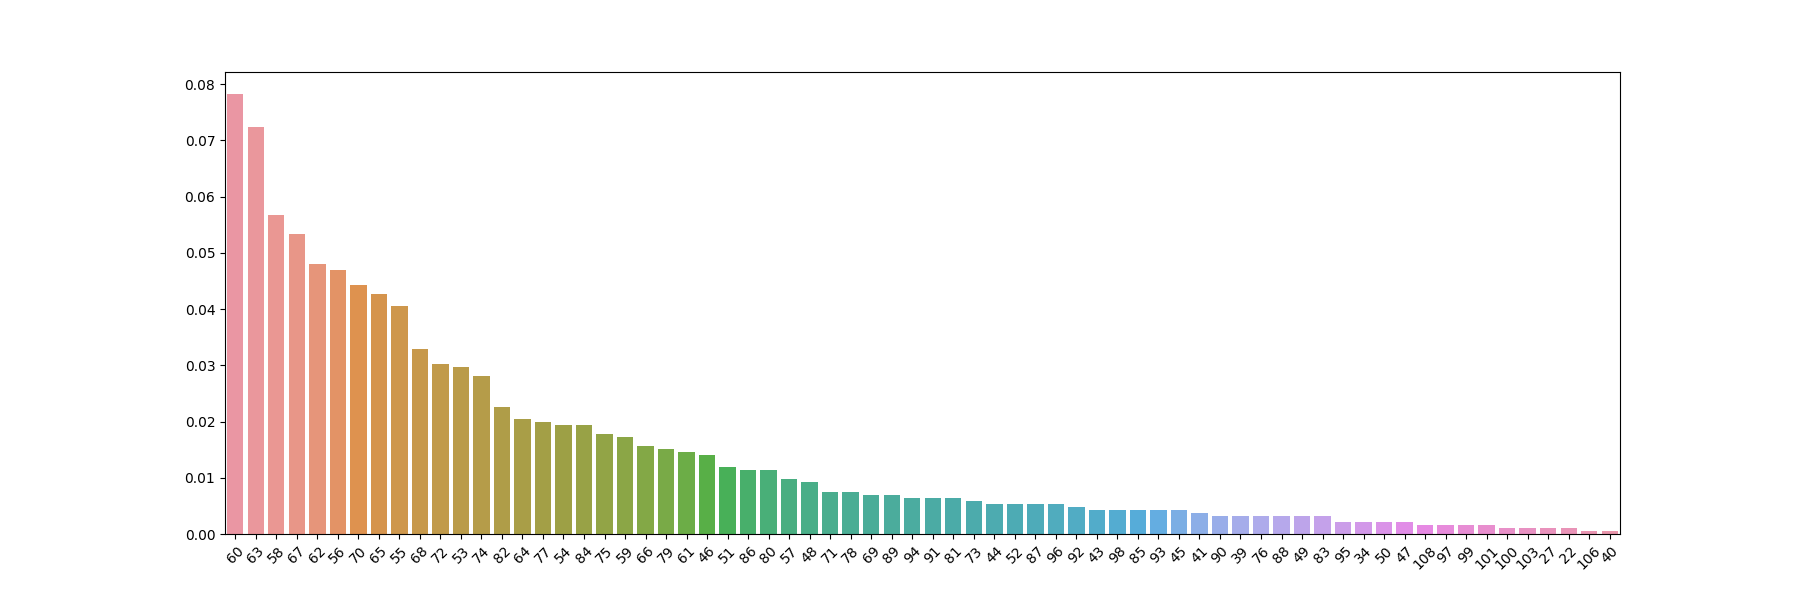

In [3]:
notes = []
for msg in mid.tracks[0]:
    if not msg.is_meta and msg.type == 'note_on':
        if msg.velocity > 0:
          notes.append(msg.note)

notes, note_freq = np.unique(notes, return_counts=True)
order = np.argsort(note_freq)
plt.figure(figsize=(18, 6))
sn.barplot(x=[str(n) for n in notes[order[::-1]]], y=note_freq[order[::-1]] / sum(note_freq))
_ = plt.xticks(rotation=45)

Why not check if these frequencies hold for all the other songs on the jazz sample?

In [4]:
all_notes = []
all_note_freq = [0] * 128
all_onoff = {
    n: {'start': [], 'end': []}
    for n in range(128)
}
all_t = []
files = os.listdir('samples/music/jazz/')
mpb = []
tpb = []
for f in files:
    t = 0
    mpb_i = None
    mid_temp = MidiFile(os.path.join('samples/music/jazz', f), clip=True)
    for msg in mid_temp.tracks[0]:
        if not msg.is_meta:
            if msg.type == 'note_on':
                t += msg.time
                if msg.velocity > 0:
                    all_notes.append(msg.note)
                    all_note_freq[msg.note] += 1
                    all_onoff[msg.note]['start'].append(t)
                else:
                    all_onoff[msg.note]['end'].append(t)
        else:
            if msg.type == 'set_tempo':
                if mpb_i is None:
                    mpb_i = msg.tempo
    all_t.append(t)  
    tpb.append(mid_temp.ticks_per_beat)
    mpb.append(mpb_i)

<IPython.core.display.Javascript object>


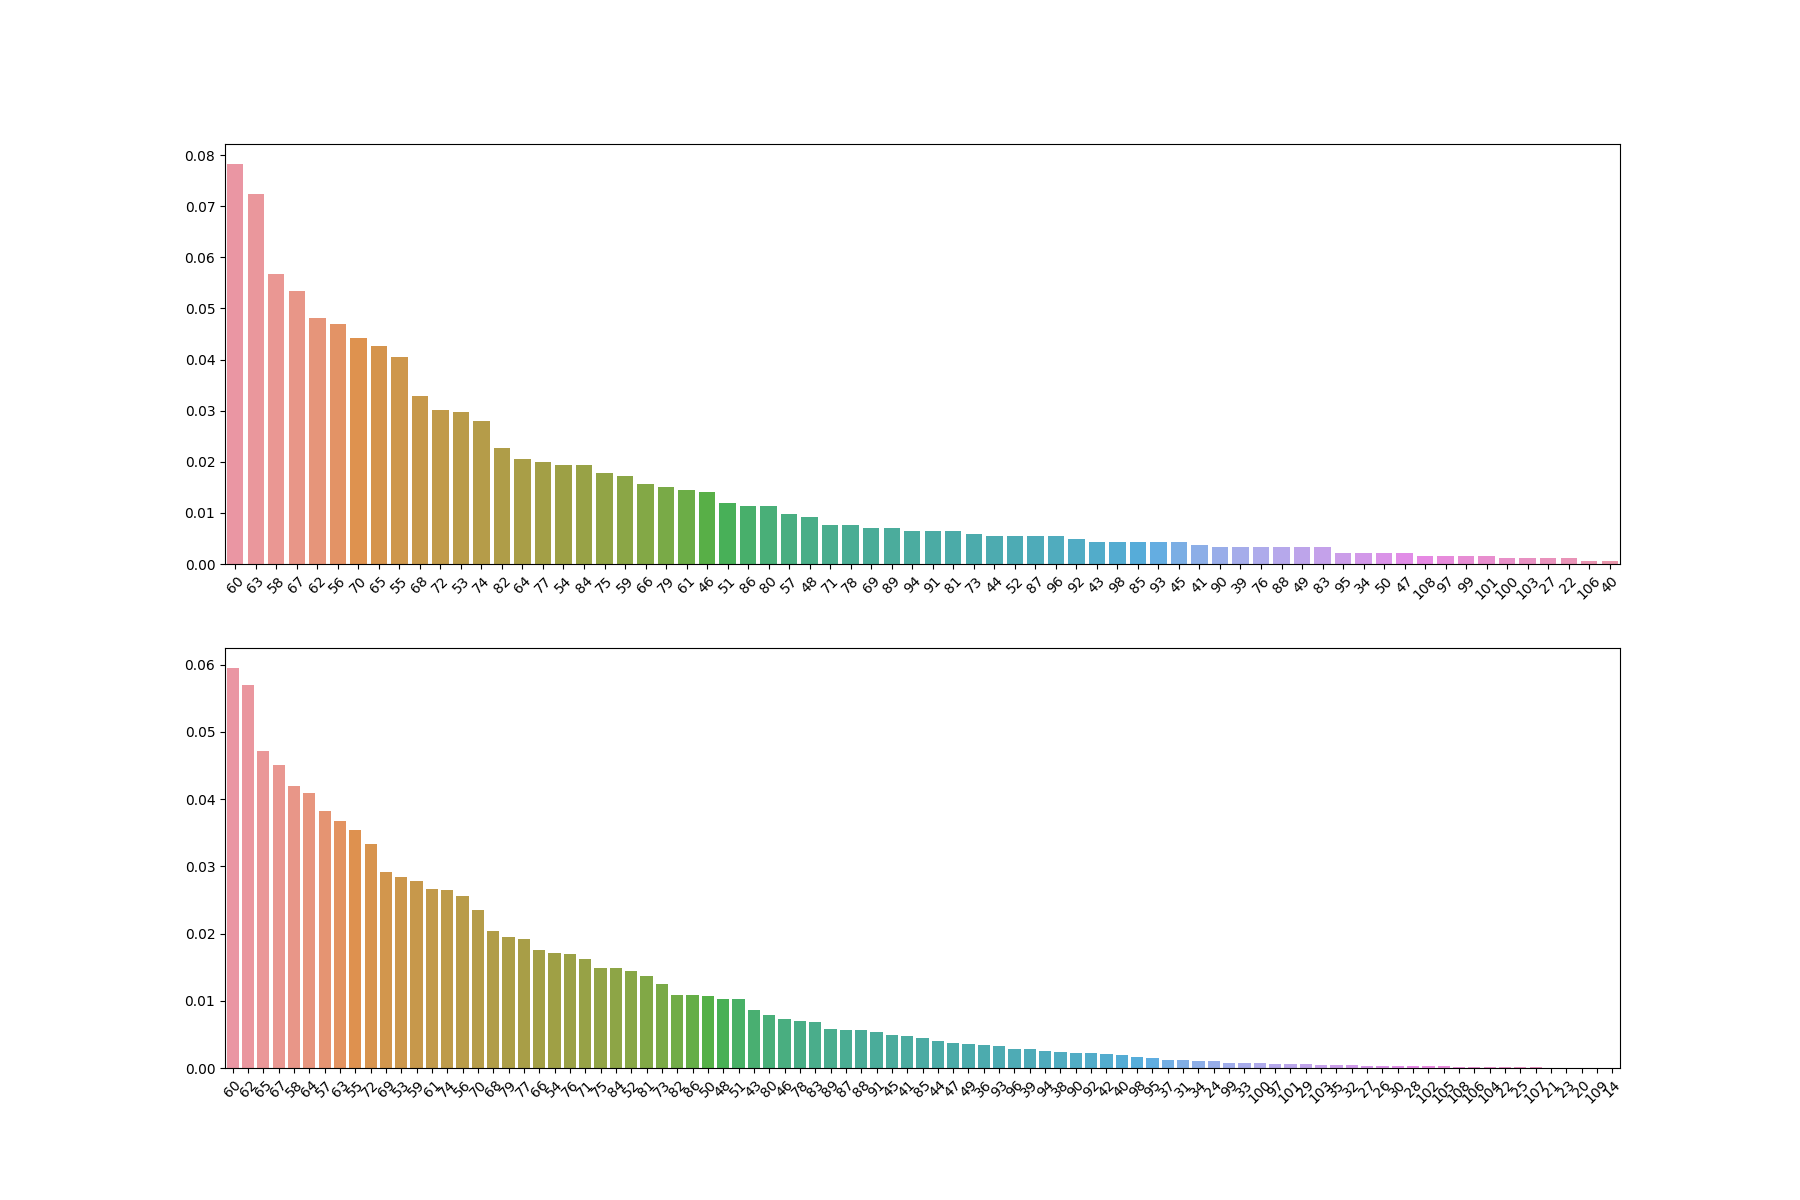

In [5]:
all_notes, all_note_freq = np.unique(all_notes, return_counts=True)
all_order = np.array(np.argsort(all_note_freq))
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
sn.barplot(x=[str(n) for n in notes[order[::-1]]], y=note_freq[order[::-1]] / sum(note_freq))
_ = plt.xticks(rotation=45)
plt.subplot(2, 1, 2)
sn.barplot(x=[str(n) for n in all_notes[all_order[::-1]]], y=all_note_freq[all_order[::-1]] / sum(all_note_freq))
_ = plt.xticks(rotation=45)

Quite the change, right? Unsurprisingly, note 60 (C4 / Middle C) is the most common note on the whole sample set! With that frequency table we could now generate a random song that follows the same distribution and give it a listen.

In [7]:
durations = []
for note, times in all_onoff.items():
    if len(times['start']) > 0:
        for t_ini, t_end in zip(times['start'], times['end']):
            durations.append(t_end - t_ini)
print(np.min(all_t), np.mean(all_t), np.max(all_t))

6371 177755.47851002865 961094


In [10]:
from mido import Message, MetaMessage, MidiFile, MidiTrack

hist, bins = np.histogram(durations, bins=1000)
bin_midpoints = bins[:-1] + np.diff(bins) / 2
dur_cdf = np.cumsum(hist)
dur_cdf = dur_cdf / dur_cdf[-1]
dur_values = np.random.normal(np.mean(durations), np.std(durations) / 8, 1000)

note_cdf = np.cumsum(all_note_freq)
note_cdf = note_cdf / note_cdf[-1]
note_values = np.random.rand(1000)
note_value_bins = np.searchsorted(note_cdf, note_values)
note_from_cdf = all_notes[note_value_bins]


mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

t = 0
for note, dur in zip(note_from_cdf, dur_values):
    track.append(Message('note_on', time=0, note=note))
    track.append(Message('note_on', time=int(dur), note=note, velocity=0))
mid.save('samples/music/test.mid')

In [11]:
from music21 import midi
mf = midi.MidiFile()
mf.open('samples/music/test.mid')
mf.read()
mf.close()
s = midi.realtime.StreamPlayer(midi.translate.midiFileToStream(mf))
s.play()

pygame 2.1.0 (SDL 2.0.16, Python 3.7.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 

Finally, let's check the duration of these songs according to the sum of all delta times. We will be using some of this MetaMessages we previously ignored. What we are looking for (as this [nice website explains](https://www.py4u.net/discuss/585187)) is the duration of ticks. Ticks is the unit of time represented by the "time" parameter on any MIDI message. Their duration depends on the tempo (miliseconds per beat) and the ticks that compose a beat. Other important aspects linked to duration would be beats per minuute (BPM) and the numerator and denominator values that define that length of a quarter note. However, these concepts are related to music composition, which we will ignore for now.

In [ ]:
song_duration = []
for f, t_i, mpb_i, tpb_i in zip(files, all_t, mpb, tpb):
    tick_duration = 1e-6 * mpb_i / tpb_i
    print(f, t_i * tick_duration, t_i, tick_duration)
    song_duration.append(t_i * tick_duration)
print(np.min(song_duration), np.mean(song_duration), np.max(song_duration), files[np.argmax(song_duration)])

In [12]:
track.sort(key=lambda m: m.time)